#2015 CAASPP test results

This notebook produces a CSV file that  compares the % MSA of San Diego county schools that have high disadvantage ( > 60% ) to the % of students that are disadvantaged. 

* [Source Website](http://caaspp.cde.ca.gov/sb2015/ResearchFileList)
* [Data Dictionary](http://caaspp.cde.ca.gov/sb2015/research_fixfileformat)

The county code for San Diego is 37.

The most important measurement values are: 
* pct_msa. The percentage of a subgroup that tested at or above the "Meets Standards" level. MSA = "Meet Standards or Above"
* mss. Mean Scale Score. The average test score for the subgroup. 

The geo_decomp() call seperates out the counties, schools and districts and limits the data to one grade. 

The first input cell restricts the data to the English Language Arts test. 


In [2]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import pandas as pd
df = pd.read_csv('../ca2015_all_csv_v1.txt', na_values='*'  )

# Entities. The school, district and county names. 
ent = pd.read_csv('../ca2015entities_csv.txt')

# Here is where we specify which test. 1 is the English / Language Arts test. 
#df = df[df['Test Id'] == 1]

# Create an identifier that combines the three codes. This ID is typical in other education files, 
# buyt oddly lacking from this one. 
def f(x):
    return "{:02d}{:05d}{:07d}".format(x['County Code'],x['District Code'],x['School Code'])
   
df['cds'] = df.apply(f, axis=1)
ent['cds'] = ent.apply(f, axis=1)
ent.set_index('cds',inplace = True) # index on cds so we can easily merge. 

county_names = ent['County Name']
school_names = ent['School Name']
district_names = ent[['District Name', 'County Name']]

# Friendly names of the subgroups. 
subgroups = pd.read_csv('../Subgroups.txt', header=None, names = ['subgroup_id','subgroup_name','category'],
                       index_col = 0)
subgroups['title'] = subgroups.apply(lambda row: row['category']+"; "+row['subgroup_name'], axis=1)
subgroup_names = subgroups.to_dict()['title']

# Calculate the percentage of students in the school, county or district who are members of the subgroup
df['pct_subgroup'] = df['Total Tested At Subgroup Level'] / df['Total Tested At Entity Level']

In [3]:
def col_subset(df):
    dfs = df[['cds', 'County Code', 'Subgroup ID', 'pct_subgroup', 'Grade', 'Test Id', 'Mean Scale Score', 
             'Percentage Standard Met and Above']]
    dfs.columns = [u'cds', 'county',  u'subgroup', u'pct_subgroup', u'grade', 'test', u'mss', u'pct_msa']
    return dfs


In [62]:
# Select just schools, and then restrict them to the disadvantaged subgroup in San Diego COunty
schools = col_subset(df[df['School Code'] != 0])
schools = schools[(schools.county == 37) & (schools.subgroup == 31)]

school_names = ent[['School Name','District Name', 'County Name']]

# Produce a data frame with just the percent disadvantaged
ed_rate = schools[(schools.subgroup == 31)][['cds', 'pct_subgroup']].copy()
ed_rate.columns = ['cds', 'pct_ec_disadvantaged']

# Turn it into a percentage ED per school
ed_rate.pct_ec_disadvantaged = np.round(ed_rate.pct_ec_disadvantaged *100,0)
ed_rate = ed_rate.groupby('cds').max()

# Join in the school names and the ED rate
high_ed_x = schools.set_index('cds').join(school_names).join(ed_rate)\
.drop(['county','subgroup','pct_subgroup','County Name'], axis=1)

# Finally, select just the schools with ED > 60%
high_ed = high_ed_x[high_ed_x.pct_ec_disadvantaged > 60].sort('pct_msa', ascending = False).dropna()


    

In [ ]:
def select_grade_test(df_in, grade, test):
    
    df = df_in[(df_in.grade == grade) & ( df_in.test == test)].copy()
    
    mean_pct_msa = df.pct_msa.mean()
    std_pct_msa = df.pct_msa.std()

    df['pct_msa_diff_std'] = (df.pct_msa - mean_pct_msa) / std_pct_msa
    df['percentile'] = st.norm.cdf(df['pct_msa_diff_std']) 
    
    df.sort('pct_msa',inplace = True, ascending = False)
    
    return df

In [119]:
# Demographics
def demographics(df, grade, test):
    schools = col_subset(df[df['School Code'] != 0])
    schools = schools[(schools.county == 37)]
    mss = schools[(schools.grade == grade) & (schools.test == test)]
    mssp = pd.pivot_table(mss,index='cds', columns='subgroup', values='pct_subgroup')


    race_eth = mssp[[74,76,77,78,80, 1]+[200,202,203,204,206,31]+[220, 222, 223, 224, 226, 111]]
    rec = [
        'Black', 'Asian', 'Filipino' , 'Latino', 'White', 'All',
        'BlackED', 'AsianED', 'FilipinoED' , 'LatinoED', 'WhiteED', 'AllED', 
        'BlackP', 'AsianP', 'FilipinoP' , 'LatinoP', 'WhiteP', 'AllP']
    
    race_eth.columns = rec
    
    race_eth =  race_eth.join(school_names)
    
    race_eth['top_race_eth'] = race_eth[ [ re for re in rec if not re.startswith('All')]] .idxmax(axis=1, skipna=True)
    
    return race_eth[['top_race_eth','School Name']+rec]

demo = demographics(df, 3, 1)

In [121]:
demo.sort('AllP', ascending = False)


,top_race_eth,School Name,Black,Asian,Filipino,Latino,White,All,BlackED,AsianED,FilipinoED,LatinoED,WhiteED,AllED,BlackP,AsianP,FilipinoP,LatinoP,WhiteP,AllP
cds,,,,,,,,,,,,,,,,,,,,
37680566975270,White,Aseltine,NaN,NaN,NaN,NaN,1.000000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000
37683126039051,White,R. Roger Rowe Elementary,0.008621,0.073276,NaN,0.086207,0.767241,1,NaN,NaN,NaN,0.008621,NaN,0.008621,0.008621,0.073276,NaN,0.077586,0.767241,0.991379
37680566117923,White,Sage Canyon,0.006652,0.272727,0.015521,NaN,0.651885,1,NaN,NaN,NaN,NaN,0.011086,0.013304,0.006652,0.270510,0.015521,NaN,0.640798,0.986696
37680806117709,White,El Camino Creek Elementary,0.002320,0.069606,0.018561,NaN,0.874710,1,NaN,NaN,NaN,NaN,0.018561,0.018561,0.002320,0.069606,0.018561,NaN,0.856148,0.981439
37683876112353,White,Carmel Creek Elementary,0.010870,0.326087,0.032609,0.065217,0.478261,1,NaN,NaN,NaN,NaN,0.010870,0.021739,0.010870,0.326087,0.032609,0.065217,0.467391,0.978261
37680560114686,White,Ocean Air,0.004016,0.411647,NaN,NaN,0.516064,1,NaN,0.010040,NaN,NaN,0.008032,0.022088,0.002008,0.401606,NaN,NaN,0.508032,0.977912
37683876106140,White,Solana Highlands Elementary,NaN,0.280488,0.024390,0.158537,0.512195,1,NaN,0.012195,NaN,NaN,0.012195,0.024390,NaN,0.268293,0.024390,0.158537,0.500000,0.975610
37680806112445,White,Olivenhain Pioneer Elementary,NaN,0.042821,0.017632,NaN,0.856423,1,NaN,NaN,NaN,NaN,0.025189,0.027708,NaN,0.042821,0.017632,NaN,0.831234,0.972292
37682960102822,White,Stone Ranch Elementary,NaN,0.337209,0.079457,0.067829,0.467054,1,NaN,0.003876,0.003876,NaN,0.017442,0.031008,NaN,0.333333,0.075581,0.063953,0.449612,0.968992


In [97]:
demo.sort('Filipino', ascending = False)

,Black,Asian,Filipino,Latino,White,BlackED,AsianED,FilipinoED,LatinoED,WhiteED,BlackP,AsianP,FilipinoP,LatinoP,WhiteP,School Name,District Name,County Name
cds,,,,,,,,,,,,,,,,,,
37683386106173,0.114345,0.020790,0.700624,0.124740,NaN,0.093555,0.016632,0.419958,0.097713,NaN,0.020790,0.004158,0.280665,0.027027,NaN,Bethune K-8,San Diego Unified,San Diego
37683386039267,0.119691,0.030888,0.401544,0.366795,0.057915,0.104247,0.027027,0.289575,0.312741,0.050193,0.015444,NaN,0.111969,0.054054,NaN,Boone Elementary,San Diego Unified,San Diego
37680230114009,0.085847,0.046404,0.387471,0.296984,0.136891,0.011601,NaN,0.076566,0.085847,0.013921,0.074246,0.039443,0.310905,0.211137,0.122970,Wolf Canyon Elementary,Chula Vista Elementary,San Diego
37683386112478,0.235537,0.066116,0.384298,0.272727,0.004132,0.210744,0.057851,0.289256,0.247934,0.004132,0.024793,NaN,0.095041,0.024793,NaN,Nye Elementary,San Diego Unified,San Diego
37683386071914,0.058376,0.170051,0.355330,0.241117,0.114213,0.032995,0.101523,0.157360,0.159898,0.043147,0.025381,0.068528,0.197970,0.081218,0.071066,Mason Elementary,San Diego Unified,San Diego
37683386106199,0.198697,0.013029,0.355049,0.335505,0.035831,0.167752,0.003257,0.224756,0.257329,0.026059,0.030945,0.009772,0.130293,0.078176,0.009772,Zamorano Elementary,San Diego Unified,San Diego
37683386089023,0.057348,0.222222,0.344086,0.186380,0.139785,0.039427,0.103943,0.150538,0.100358,0.046595,0.017921,0.118280,0.193548,0.086022,0.093190,Hickman Elementary,San Diego Unified,San Diego
37683386040067,0.203390,NaN,0.338983,0.225989,0.129944,0.158192,NaN,0.197740,0.135593,0.079096,0.045198,NaN,0.141243,0.090395,0.050847,Perry Elementary,San Diego Unified,San Diego
37680230101592,0.033281,0.050713,0.331220,0.453249,0.106181,0.015848,0.006339,0.038035,0.158479,0.007924,0.017433,0.044374,0.293185,0.294770,0.098257,Hedenkamp (Anne And William) Elementary,Chula Vista Elementary,San Diego


,grade,test,mss,pct_msa,School Name,District Name,pct_ec_disadvantaged,pct_msa_diff_std,percentile
cds,,,,,,,,,
37242060124206,3,1,2484.1,77,America's Finest Charter,America's Finest Charter,94,3.886392,0.999949
37680236037964,3,1,2453.3,63,Finney (Myrtle S.) Elementary,Chula Vista Elementary,70,2.789954,0.997364
37680236037972,3,1,2452.5,58,Palomar Elementary,Chula Vista Elementary,74,2.398369,0.991766
37683386093256,3,1,2435.9,58,Miller Elementary,San Diego Unified,61,2.398369,0.991766
37683386039481,3,1,2443.3,56,Dewey Elementary,San Diego Unified,67,2.241735,0.987511
37683386039804,3,1,2425.7,54,Juarez Elementary,San Diego Unified,66,2.085101,0.981470
37683386039887,3,1,2438.1,53,Lindbergh/Schweitzer Elementary,San Diego Unified,71,2.006784,0.977614
37683386077317,3,1,2427.6,53,Penn Elementary,San Diego Unified,76,2.006784,0.977614
37683386039309,3,1,2428.4,53,Cadman Elementary,San Diego Unified,62,2.006784,0.977614


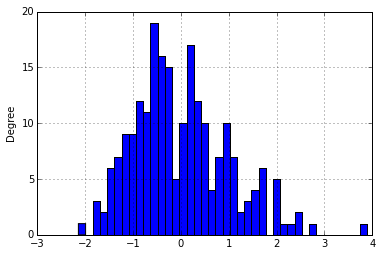

In [64]:
select_grade_test(high_ed, 3,1).pct_msa_diff_std.plot(kind='hist', bins = 40)

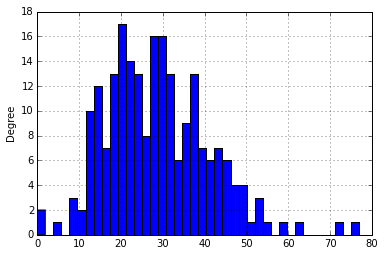

In [54]:

high_ed_2[high_ed_2.grade == 3].pct_msa.plot(kind='hist', bins = 40)